In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from rich import print

df_sel = pd.read_csv('train_sel_hclust.csv').sample(frac=0.1)

### RandomForest

In [2]:
X_train, X_val, y_train, y_val = train_test_split(
    df_sel.drop(['is_benign', 'category', 'attack'], axis=1),
    df_sel['category'],
    train_size=0.7
)

#### Optimising Hyperparameters

This time, we used a Bayesian Optimisation, with 3-folds cross validation, to choose the best parameters for our model.

This method enables a more intelligent search, since, instead of evaluating all combinations in the parameter grid, it builds a probabilistic model of the performance function and explores the parameter space accordingly. Thus:
- It's possible to assign parameter ranges (for numeric parameters)
- This search method it's more efficient: it needs fewer iterations


In [3]:
# Adjusting our scorer to fit a multiclass classification

from sklearn.metrics import make_scorer

# Define average_score to take y_true and y_pred
def average_score(y_true, y_pred):
    return (accuracy_score(y_true, y_pred) + 
            precision_score(y_true, y_pred, average='macro') + 
            recall_score(y_true, y_pred, average='macro') + 
            f1_score(y_true, y_pred, average='macro')) / 4

# Use make_scorer with the fixed average_score
average_scorer = make_scorer(average_score)

In [4]:
from skopt import BayesSearchCV

# Define RandomForestClassifier
rnd_forest = RandomForestClassifier()

# Define the parameter space for Bayesian optimization
param_space = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': (5, 50),
    'n_estimators': (20,100),
    'random_state': [42]
}

# Set up BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=rnd_forest,
    search_spaces=param_space,
    n_iter=25,  # Number of parameter combinations to evaluate
    cv=3,
    scoring=average_scorer,  # Our custom scoring metric
    verbose=0,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the Bayesian optimization
bayes_search.fit(X_train, y_train)

# Access the best model and parameters
best_model = bayes_search.best_estimator_
print("Best Parameters by Bayesian Optimization:", bayes_search.best_params_)

# Evaluate on validation set
#test_score = best_model.score(X_val, y_val)
#print("Test Set Accuracy:", test_score)

Best Parameters by Bayesian Optimization:
OrderedDict({'criterion': 'entropy', 'max_depth': 17, 'n_estimators': 65, 'random_state': 42})

#### Prediction and Evaluation

In [5]:
y_pred = best_model.predict(X_val)

In [6]:
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average='macro')
rec = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

metrics_rnd = [
    acc,
    prec,
    rec,
    f1
]
print("\nOverall Report:")
print(f"Accuracy:        {acc:.5f}")
print(f"Precision:       {prec:.5f}")
print(f"Recall:          {rec:.5f}")
print(f"F1:              {f1:.5f}")

print("\n\nDetailed Report:")
print(classification_report(y_val, y_pred))

Overall Report:

Accuracy:        0.99625

Precision:       0.96528

Recall:          0.97049

F1:              0.96775

Detailed Report:

precision    recall  f1-score   support

      BENIGN       0.94      0.97      0.95      1342
        DDoS       1.00      1.00      1.00     33029
         DoS       1.00      1.00      1.00     17931
        MQTT       0.99      0.99      0.99      3110
       RECON       0.99      0.96      0.97      1608
    SPOOFING       0.88      0.91      0.89       513

    accuracy                           1.00     57533
   macro avg       0.97      0.97      0.97     57533
weighted avg       1.00      1.00      1.00     57533

##### Confusion Matrix with raw counts

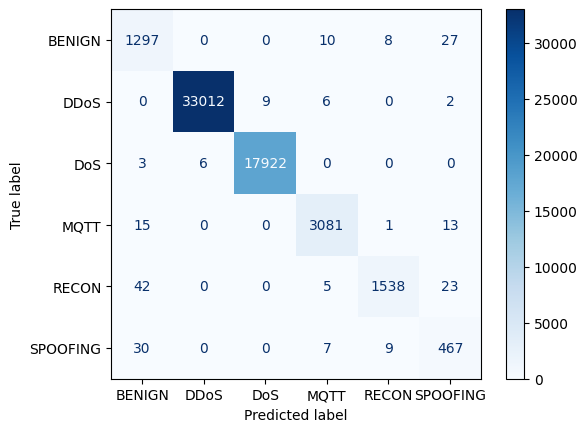

In [7]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
plt.show()

##### Confusion Matrix with normalised counts

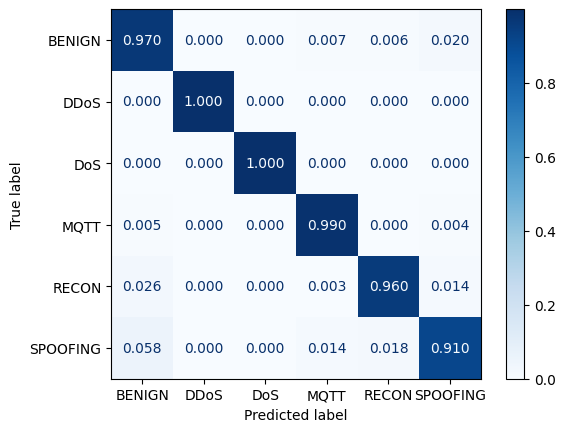

In [8]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues', normalize='true')

# Rounding the decimal points
ax = plt.gca()  # Get current axes
for text in ax.texts:  # Iterate over text annotations
    value = float(text.get_text())  # Get the value of the annotation
    text.set_text(f"{value:.3f}")  # Set the formatted text with 3 decimal points


plt.show()